# Project Question

> Create a search function to search in a NAS space for the best performing **CNN architecture** on fashion-mnist.

Your task is to create a search function which searches for the model genome string that provides the best accuracy while using the least number of parameters.

Your program will return a model genome string (described below) which can be fed to a train function (provided below) to get the lowest parameter count and best accuracy after training.

**This is an open research problem**. You can use any method to search for the best genome and there might not be a perfect solution possible (prefect in the sense of maximum accuracy with minimum parameters). You will likely find tradeoffs between accuracy and number of parameters and you must balance such tradeoffs at your discretion.

> Aim for a search function that finds a genome with accuracy at least 75%.

You are encouraged to experiment with different techniques and apply your intuition to find a good search algorithm.

## CNN Architecture Constraints

Your search algorithm should search for models with the following basic structure.

Sequential model (no skip connections) having the following layers,
- Any number of normal(NC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A normal CNN layer has the following constraints,
    - `stride=1`
    - `padding=same`
    - `1 <= kernel size < 8`
    - Any of the following activation functions,
      - relu
      - sigmoid
      - tanh
      - swish
      - gelu
- **Exactly** 2 reduction(RC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A reduction layer has the **same** constraints as the normal layer except the following,
    - `stride=2`
    - `padding=valid`
- **Exactly** the following structure as the **final layers**,
  - First, a Global Average Pooling 2D layer.
    - `torch.nn.AvgPool2d(kernel_size=layer_input_image_size)` or `tf.keras.layers.GlobalAveragePooling2D`
  - Then, a Fully Connected/Dense layer with 64 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(64)` or `tf.keras.layers.Dense(64)`
  - Then, a Fully Connected/Dense layer with 10 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(10)` or `tf.keras.layers.Dense(10)`


The normal(NC) and reduction(RC) layers can be in **any order** as long as the constraints above are maintained.

The final layers of you model should be exactly as mentioned in these constraints.

All of the above contraints **apply only to your final output**. During searching for the best architecture you can do whatever you want.

Once your algorithm finds the best architecture, it should represent the architecture as a genome string (explained below) which will be fed to the training function given below to get the final accuracy.

In [ ]:
!python3 --version

Python 3.7.12


In [ ]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [ ]:
tf.__version__

'2.7.0'

### set deterministic flags

In [ ]:
# https://jackd.github.io/posts/deterministic-tf-part-1/
# https://www.tensorflow.org/datasets/determinism

SEED = 42

# weight initialization
# helps with randomness in both tf.keras.layers weight initialization and dataset.shuffle
tf.random.set_seed(SEED)

# for generators if any
tf.random.set_global_generator(tf.random.Generator.from_seed(SEED))

# makes many GPU operations deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


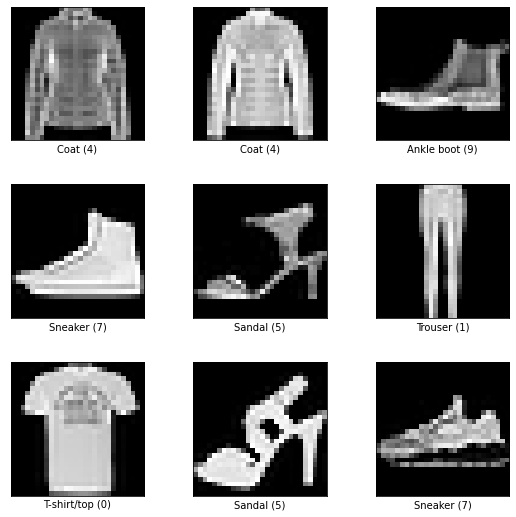

In [ ]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]

__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  # optimizer = tfa.optimizers.AdamW(
  #         learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
  #           initial_learning_rate=lr,
  #           decay_steps=len(__DS_TRAIN)*10,
  #           decay_rate=lr_decay,
  #         )

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model


In [ ]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "RC 10 3 tanh;NC 20 3 relu;RC 10 3 swish;FL swish;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')
  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 10)        100       
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 20)        1820      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 10)          1810      
                                                                 
 global_average_pooling2d (G  (None, 10)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

In [ ]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, epochs=10, return_model=False, verbose: int = 1, lr: float = None, lr_decay: float = None):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')

  if verbose > 1:
    model.summary()

  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=epochs,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )

  if return_model:
      return model

  # delete model
  del model

  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'best test accuracy: {best_history["val_accuracy"]}')
    print(f'num_params: {n_params}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)
  

In [ ]:
#@title Use this form to train specific genomes
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 8 3 relu;RC 16 3 relu;NC 16 3 relu;RC 16 3 relu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr =  .01#@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 8 3 relu;RC 16 3 relu;NC 16 3 relu;RC 16 3 relu;FL relu;
Model params: 7626
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        1168      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 16)        2320      
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 16)          2320      
                                                                 
 global_average_pooling2d_14  (None, 16)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)        

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8269000053405762
Return value: (0.8269000053405762, 0.8335000276565552, 7626)


In [ ]:
#@title Deep model genome example
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Training genome: NC 64 1 gelu;NC 64 3 gelu;NC 64 1 gelu;RC 128 3 gelu;NC 128 1 gelu;NC 128 3 gelu;NC 128 1 gelu;RC 256 3 gelu;FL relu;
Model params: 607946
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_0_NC (Conv2D)          (None, 28, 28, 64)        128       
_________________________________________________________________
Layer_1_NC (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
Layer_2_NC (Conv2D)          (None, 28, 28, 64)        4160      
_________________________________________________________________
Layer_3_RC (Conv2D)          (None, 13, 13, 128)       73856     
_________________________________________________________________
Layer_4_NC (Conv2D)          (None, 13, 13, 128)       16512     
_________________________________________________________________
Layer_5_NC (Conv2D)          (

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7461000084877014
Return value: (0.7461000084877014, 0.7610833048820496, 607946)


## Hints

- Consider caching genome results for faster querying.
  - This has a risk. The training process itself is non-deterministic and thus training the same genome multiple times can sometimes give drastically different results. Generally such difference in accuracy of the same genome is small but sometimes it be upto 30%.
- Consider saving your search algorithm state such that it can resume from a previous search point if it gets interrupted due to a crash or colab time restrictions.
  - Google colab is free and hence it has time limits on how long you can use the GPU. If you implement checkpointing in your code such that it saves checkpoints on your GDrive, you can save a lot of time when such interruptions happen.
  - You can mount your GDrive to colab and save/load files from your drive folders.
- Don't forget to enable GPU in colab.
  - https://colab.research.google.com/notebooks/gpu.ipynb
- If colab shows errors in code that was working before try to do `Runtime->Restart Runtime`. This is especially true if you stopped execution while a model was being trained.
  - You can also try `Runtime->Factory Reset Runtime` to get a clean slate (revert installed libraries to colab defaults).

# Answer: Initial Trial
Write your answer and its code under this section.

## Imports

In [17]:
import pandas as pd
import numpy as np
import math
import random
import time
from collections import deque, OrderedDict
from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## display images

In [15]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

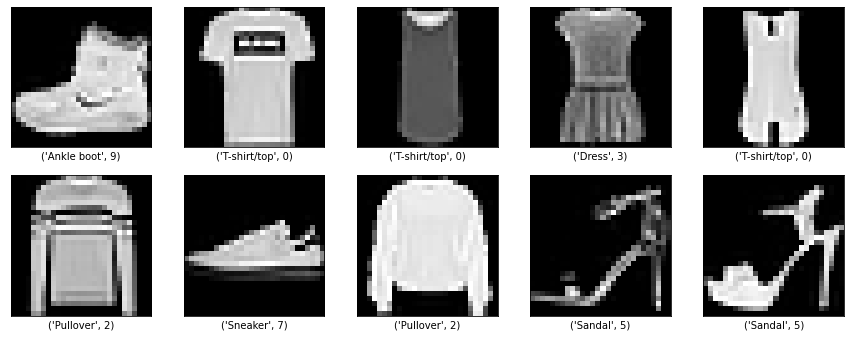

In [18]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel((class_names[y_train[i]], (y_train[i])))
plt.show()

## train:test split

In [19]:
# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_test.shape, x_test.shape

((10000, 28, 28, 1), (10000, 28, 28, 1))

In [22]:
# normalization
x_train= x_train / 255.0
x_test = x_test / 255.0

In [23]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

## model experiments

In [ ]:
def build_model_v2(layers, ks, filters, activations, from_logits=False, print_summary=False):
    input_layer = Input(shape=(28,28,1))

    for i, layer in enumerate(layers):
        # first layer is NC with input_layer
        if i == 0:
          op = Conv2D(filters=filters[i], kernel_size=ks[i], strides=1, padding="same", 
                        activation=activations[i], name=f'Layer_{i}_NC')(input_layer)
          continue
        if layer == "nc":
            op = Conv2D(filters=filters[i], kernel_size=ks[i], strides=1, padding="same", 
                        activation=activations[i], name=f'Layer_{i}_NC')(op)
        if layer == "rc_conv":
            op = Conv2D(filters=filters[i], kernel_size=ks[i], strides=2, padding="valid", 
                        activation=activations[i], name=f'Layer_{i}_RC')(op)
        if layer == "rc":
            op = MaxPool2D(pool_size=2, strides=2, padding="valid", name=f'Layer_{i}_RC')(op)
            
    # final layers
    op = GlobalAveragePooling2D()(op)

    # dense layers 1
    op = Dense(units=64, activation='relu', name='dense_0')(op)

    # dense layer 2
    if from_logits:
      print("from_logits:", from_logits)
      op = Dense(units=10, activation='relu', name = 'dense_1')(op)
    else:
      op = Dense(units=10, activation='softmax', name = 'dense_1')(op)

    # Model creation
    model = Model(inputs=input_layer, outputs=op)
    
    if print_summary:
        print(model.summary())

    return model

### base version

In [ ]:
ks = [3, 3, 3, 3]
filters = [8, 16, 16, 32]
layers = ["nc", "rc", "nc", "rc"]
activations = ['relu']*len(layers)

model = build_model_v2(layers, ks, filters, activations, print_summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_RC (MaxPooling2D)   (None, 14, 14, 8)         0         
                                                                 
 Layer_2_NC (Conv2D)         (None, 14, 14, 16)        1168      
                                                                 
 Layer_3_RC (MaxPooling2D)   (None, 7, 7, 16)          0         
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
# model_folder = '/content/drive/MyDrive/DAI/A1/q2-models/'
# checkpoint_callback = ModelCheckpoint(model_folder + 'vgg16_{epoch:02d}_{val_accuracy:.4f}.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
earlystop_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [ ]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer= optimizer, loss=sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
epochs = 30
batch_size = 256

history = model.fit(x=x_train, y=y_train, 
                batch_size=batch_size, 
                epochs = epochs,
                validation_data=(x_test, y_test), 
                callbacks=[earlystop_callback])

Epoch 1/30
235/235 [==============================] - 33s 11ms/step - loss: 2.2118 - accuracy: 0.1617 - val_loss: 2.0411 - val_accuracy: 0.2289
Epoch 2/30
235/235 [==============================] - 2s 10ms/step - loss: 1.6433 - accuracy: 0.3982 - val_loss: 1.2611 - val_accuracy: 0.5230
Epoch 3/30
235/235 [==============================] - 2s 9ms/step - loss: 1.1024 - accuracy: 0.5860 - val_loss: 1.0515 - val_accuracy: 0.6080
Epoch 4/30
235/235 [==============================] - 2s 9ms/step - loss: 0.9376 - accuracy: 0.6526 - val_loss: 0.9355 - val_accuracy: 0.6506
Epoch 5/30
235/235 [==============================] - 2s 9ms/step - loss: 0.8697 - accuracy: 0.6744 - val_loss: 0.8393 - val_accuracy: 0.6881
Epoch 6/30
235/235 [==============================] - 2s 9ms/step - loss: 0.8214 - accuracy: 0.6922 - val_loss: 0.8243 - val_accuracy: 0.6917
Epoch 7/30
235/235 [==============================] - 2s 9ms/step - loss: 0.8026 - accuracy: 0.6981 - val_loss: 0.7993 - val_accuracy: 0.7008
Epo

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,2.211761,0.161733,2.041076,0.2289
1,1.643322,0.398167,1.261120,0.5230
2,1.102405,0.585967,1.051478,0.6080
3,0.937620,0.652633,0.935488,0.6506
4,0.869716,0.674417,0.839314,0.6881
5,0.821357,0.692167,0.824324,0.6917
6,0.802628,0.698150,0.799256,0.7008
7,0.772266,0.709983,0.792855,0.7037
8,0.760731,0.715733,0.832017,0.6769
9,0.736512,0.724017,0.737737,0.7219


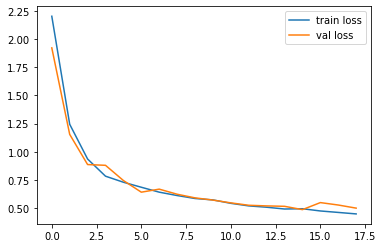

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()

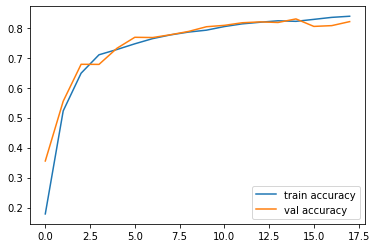

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

### base version with RC


In [ ]:
ks = [3, 3, 3, 3]
filters = [8, 16, 16, 16]
layers = ["nc", "rc_conv", "nc", "rc_conv"]
activations = ['relu']*len(layers)

model2 = build_model_v2(layers, ks, filters, activations, print_summary=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        1168      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 16)        2320      
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 16)          2320      
                                                                 
 global_average_pooling2d_5   (None, 16)               0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

optimizer = SGD(learning_rate=0.01, momentum=0.9)
model2.compile(optimizer= optimizer, loss=sparse_categorical_crossentropy, metrics=['accuracy'])

epochs = 30
batch_size = 256

history2 = model2.fit(x=x_train, y=y_train, 
                batch_size=batch_size, 
                epochs = epochs,
                validation_data=(x_test, y_test), 
                callbacks=[earlystop_callback])

Epoch 1/30
235/235 [==============================] - 4s 12ms/step - loss: 2.1680 - accuracy: 0.1983 - val_loss: 1.4374 - val_accuracy: 0.4714
Epoch 2/30
235/235 [==============================] - 2s 10ms/step - loss: 1.0518 - accuracy: 0.5904 - val_loss: 0.8322 - val_accuracy: 0.6937
Epoch 3/30
235/235 [==============================] - 2s 10ms/step - loss: 0.7905 - accuracy: 0.7040 - val_loss: 0.7325 - val_accuracy: 0.7241
Epoch 4/30
235/235 [==============================] - 2s 10ms/step - loss: 0.7219 - accuracy: 0.7271 - val_loss: 0.6862 - val_accuracy: 0.7501
Epoch 5/30
235/235 [==============================] - 3s 11ms/step - loss: 0.6532 - accuracy: 0.7544 - val_loss: 0.7006 - val_accuracy: 0.7324
Epoch 6/30
235/235 [==============================] - 2s 10ms/step - loss: 0.6223 - accuracy: 0.7679 - val_loss: 0.6211 - val_accuracy: 0.7717
Epoch 7/30
235/235 [==============================] - 2s 10ms/step - loss: 0.5973 - accuracy: 0.7799 - val_loss: 0.6098 - val_accuracy: 0.7776

### base model with Adam



In [ ]:
ks = [3, 3, 3, 3]
filters = [8, 16, 16, 16]
layers = ["nc", "rc_conv", "nc", "rc_conv"]
activations = ['relu']*len(layers)

model5 = build_model_v2(layers, ks, filters, activations, from_logits=True, print_summary=True)

from_logits: True
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        1168      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 16)        2320      
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 16)          2320      
                                                                 
 global_average_pooling2d_11  (None, 16)               0         
  (GlobalAveragePooling2D)                                       
                                        

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

optimizer = Adam(learning_rate=0.01)
model5.compile(optimizer= optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 30
batch_size = 256

history5 = model5.fit(x=x_train, y=y_train, 
                batch_size=batch_size, 
                epochs = epochs,
                validation_data=(x_test, y_test), 
                callbacks=[earlystop_callback])

Epoch 1/30
235/235 [==============================] - 3s 11ms/step - loss: 1.5802 - accuracy: 0.4045 - val_loss: 1.3542 - val_accuracy: 0.4930
Epoch 2/30
235/235 [==============================] - 2s 10ms/step - loss: 1.2442 - accuracy: 0.5182 - val_loss: 1.1988 - val_accuracy: 0.5305
Epoch 3/30
235/235 [==============================] - 2s 10ms/step - loss: 1.1481 - accuracy: 0.5477 - val_loss: 1.1279 - val_accuracy: 0.5559
Epoch 4/30
235/235 [==============================] - 2s 10ms/step - loss: 1.1099 - accuracy: 0.5618 - val_loss: 1.1968 - val_accuracy: 0.5241
Epoch 5/30
235/235 [==============================] - 2s 10ms/step - loss: 1.0925 - accuracy: 0.5653 - val_loss: 1.1007 - val_accuracy: 0.5610
Epoch 6/30
235/235 [==============================] - 2s 10ms/step - loss: 1.0660 - accuracy: 0.5730 - val_loss: 1.0922 - val_accuracy: 0.5676
Epoch 7/30
235/235 [==============================] - 2s 10ms/step - loss: 0.8883 - accuracy: 0.6503 - val_loss: 0.8508 - val_accuracy: 0.6660

### base model with AdamW



In [ ]:
len(__DS_TRAIN), len(__DS_TEST)

(60000, 10000)

In [ ]:
ks = [3, 3, 3, 3]
filters = [8, 16, 16, 16]
layers = ["nc", "rc_conv", "nc", "rc_conv"]
activations = ['relu']*len(layers)

model4 = build_model_v2(layers, ks, filters, activations, from_logits=True, print_summary=True)

from_logits: True
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        1168      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 16)        2320      
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 16)          2320      
                                                                 
 global_average_pooling2d_9   (None, 16)               0         
 (GlobalAveragePooling2D)                                        
                                         

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lr = 1e-3
lr_decay = 0.1

optimizer =tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
          )

model4.compile(optimizer= optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 30
batch_size = 256

history4 = model4.fit(x=x_train, y=y_train, 
                batch_size=batch_size, 
                epochs = epochs,
                validation_data=(x_test, y_test), 
                callbacks=[earlystop_callback])

Epoch 1/30
235/235 [==============================] - 4s 13ms/step - loss: 1.7712 - accuracy: 0.4292 - val_loss: 1.3454 - val_accuracy: 0.5561
Epoch 2/30
235/235 [==============================] - 3s 11ms/step - loss: 1.2671 - accuracy: 0.5741 - val_loss: 1.2381 - val_accuracy: 0.5817
Epoch 3/30
235/235 [==============================] - 2s 11ms/step - loss: 1.1925 - accuracy: 0.5933 - val_loss: 1.1774 - val_accuracy: 0.5997
Epoch 4/30
235/235 [==============================] - 2s 10ms/step - loss: 1.1560 - accuracy: 0.6020 - val_loss: 1.1539 - val_accuracy: 0.6100
Epoch 5/30
235/235 [==============================] - 2s 11ms/step - loss: 1.1280 - accuracy: 0.6112 - val_loss: 1.1330 - val_accuracy: 0.6159
Epoch 6/30
235/235 [==============================] - 2s 11ms/step - loss: 1.1035 - accuracy: 0.6171 - val_loss: 1.1046 - val_accuracy: 0.6193
Epoch 7/30
235/235 [==============================] - 3s 11ms/step - loss: 1.0898 - accuracy: 0.6208 - val_loss: 1.0984 - val_accuracy: 0.6227

In [ ]:
ks = [3, 3, 3, 3]
filters = [8, 16, 16, 16]
layers = ["nc", "rc_conv", "nc", "rc_conv"]
activations = ['relu']*len(layers)

model6 = build_model_v2(layers, ks, filters, activations, from_logits=True, print_summary=True)

from_logits: True
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        1168      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 16)        2320      
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 16)          2320      
                                                                 
 global_average_pooling2d_15  (None, 16)               0         
  (GlobalAveragePooling2D)                                       
                                        

In [ ]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lr = .01
lr_decay = 0.01

optimizer =tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
          )

model6.compile(optimizer= optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 30
batch_size = 256

history4 = model6.fit(x=x_train, y=y_train, 
                batch_size=batch_size, 
                epochs = epochs,
                validation_data=(x_test, y_test), 
                callbacks=[earlystop_callback])

Epoch 1/30
235/235 [==============================] - 4s 13ms/step - loss: 1.9884 - accuracy: 0.2873 - val_loss: 1.8376 - val_accuracy: 0.3205
Epoch 2/30
235/235 [==============================] - 3s 11ms/step - loss: 1.8019 - accuracy: 0.3410 - val_loss: 1.7806 - val_accuracy: 0.3439
Epoch 3/30
235/235 [==============================] - 3s 11ms/step - loss: 1.7464 - accuracy: 0.3560 - val_loss: 1.7769 - val_accuracy: 0.3591
Epoch 4/30
235/235 [==============================] - 3s 11ms/step - loss: 1.7148 - accuracy: 0.3663 - val_loss: 1.7137 - val_accuracy: 0.3758
Epoch 5/30
235/235 [==============================] - 3s 11ms/step - loss: 1.6986 - accuracy: 0.3736 - val_loss: 1.7164 - val_accuracy: 0.3709
Epoch 6/30
235/235 [==============================] - 3s 11ms/step - loss: 1.6884 - accuracy: 0.3773 - val_loss: 1.7010 - val_accuracy: 0.3805
Epoch 7/30
235/235 [==============================] - 3s 11ms/step - loss: 1.6760 - accuracy: 0.3826 - val_loss: 1.6905 - val_accuracy: 0.3914

## Genetic Algorithm

#### build random architecture

In [ ]:
# sample_genome="NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;"
def build_random_model(print_summary=False):
    num_nc = random.choice(nc_layer_counts)
    kernel_size = random.choice(kernel_sizes)
    filter_size = random.choice(filter_sizes)
    #activation_fns = random.choice(activation_functions)

    # we can restrict final activation
    final_activation_fns = random.choice(activation_functions)
    
    rc_layer_count = 0

    genome_str = ""

    # if print_summary:
    #   print(f"num_nc: {num_nc} | kernel_size: {kernel_size} | final_activation_fns: {final_activation_fns}")

    input_layer = Input(shape=(28,28,1))

    # TODO: filter size can be random but in decreasing order 
    for i in range(num_nc):
        # first layer is NC with input_layer
        if i == 0:
          op = input_layer

        filter_size = random.choice(filter_sizes)
        activation_fns = random.choice(activation_functions)

        op = Conv2D(filters=filter_size, kernel_size=kernel_size, strides=1, padding="same", 
                      activation=activation_fns, name=f'Layer_{i}_NC')(op)
        genome_str += f"NC {filter_size} {kernel_size} {activation_fns};"           
        
        # randomly decide to put rc layer:
        if rc_layer_count < 2:
          layer = random.choice(layers)
          
          if layer == "RC":
            filter_size = random.choice(filter_sizes)
            activation_fns = random.choice(activation_functions)

            op = Conv2D(filters=filter_size, kernel_size=kernel_size, strides=2, padding="valid", 
                          activation=activation_fns, name=f'Layer_{rc_layer_count}_RC')(op)
            rc_layer_count += 1
            genome_str += f"RC {filter_size} {kernel_size} {activation_fns};" 
            
    while rc_layer_count < 2:
        filter_size = random.choice(filter_sizes)
        activation_fns = random.choice(activation_functions)

        op = Conv2D(filters=filter_size, kernel_size=kernel_size, strides=2, padding="valid", 
                          activation=activation_fns, name=f'Layer_{rc_layer_count}_RC')(op)
        rc_layer_count += 1
        genome_str += f"RC {filter_size} {kernel_size} {activation_fns};"
            
    # final layers
    op = GlobalAveragePooling2D()(op)

    # dense layers 1
    op = Dense(units=64, activation=final_activation_fns, name='dense_0')(op)

    # dense layer 2
    op = Dense(units=10, activation=final_activation_fns, name = 'dense_1')(op)

    genome_str += f"FL {final_activation_fns};"

    # Model creation
    model = Model(inputs=input_layer, outputs=op)
    
    if print_summary:
        print(model.summary())

    return genome_str


In [ ]:
# ks = [3, 3, 3, 3]
# filters = [8, 16, 16, 32]
# layers = ["nc", "rc", "nc", "rc"]
# activations = ['relu']*len(layers)

# model = build_random_model(layers, ks, filters, activations, print_summary=True)

# configs
layers = ["NC", "RC"]
nc_layer_counts = list(range(1, 4))
kernel_sizes= list(range(3, 6))
filter_sizes = list(range(4,17,2))
activation_functions = ['relu','sigmoid','tanh','swish','gelu']

genome_str = build_random_model(print_summary=True)
print(genome_str)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        272       
                                                                 
 Layer_0_RC (Conv2D)         (None, 13, 13, 4)         1028      
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 14)        910       
                                                                 
 Layer_1_RC (Conv2D)         (None, 5, 5, 10)          2250      
                                                                 
 global_average_pooling2d_3   (None, 10)               0         
 (GlobalAveragePooling2D)                                        
                                                             

In [ ]:
# configs
MAX_POPULATION_SIZE = 5
population = deque(maxlen = MAX_POPULATION_SIZE)
train_log = []

In [ ]:
while len(population) < MAX_POPULATION_SIZE:
    genome_str = build_random_model(print_summary=False)
    print("***genome string:", genome_str, "***")

    test_acc, train_acc, num_of_param = train_model(genome_str, epochs=2, verbose=2, lr=0.01, lr_decay=0.1)
    population.append(genome_str)
    train_log.append([test_acc, train_acc, num_of_param])
    print("\n")

***genome string: NC 16 5 tanh;NC 12 5 tanh;RC 10 5 tanh;NC 6 5 tanh;RC 10 5 tanh;FL swish; ***
Training genome: NC 16 5 tanh;NC 12 5 tanh;RC 10 5 tanh;NC 6 5 tanh;RC 10 5 tanh;FL swish;
Model params: 12608
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        416       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 12)        4812      
                                                                 
 Layer_2_RC (Conv2D)         (None, 12, 12, 10)        3010      
                                                                 
 Layer_3_NC (Conv2D)         (None, 12, 12, 6)         1506      
                                                                 
 Layer_4_RC (Conv2D)         (None, 4, 4, 10)          1510      
                                             

Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

best test accuracy: 0.7301999926567078
num_params: 12608


***genome string: NC 6 3 sigmoid;RC 16 3 sigmoid;RC 12 3 sigmoid;FL swish; ***
Training genome: NC 6 3 sigmoid;RC 16 3 sigmoid;RC 12 3 sigmoid;FL swish;
Model params: 4162
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 6)         60        
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        880       
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 12)          1740      
                                                                 
 global_average_pooling2d_7   (None, 12)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)     

Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

best test accuracy: 0.10000000149011612
num_params: 4162


***genome string: NC 8 3 swish;NC 8 3 swish;RC 8 3 swish;NC 6 3 swish;RC 10 3 swish;FL sigmoid; ***
Training genome: NC 8 3 swish;NC 8 3 swish;RC 8 3 swish;NC 6 3 swish;RC 10 3 swish;FL sigmoid;
Model params: 3590
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         80        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 8)         584       
                                                                 
 Layer_2_RC (Conv2D)         (None, 13, 13, 8)         584       
                                                                 
 Layer_3_NC (Conv2D)         (None, 13, 13, 6)         438       
                                                                 
 Layer_4_RC (Conv2D)         (None, 6, 6, 10)

Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/2


0/469           ETA: ?s - 

best test accuracy: 0.10000000149011612
num_params: 3590


***genome string: NC 12 5 tanh;RC 8 5 tanh;NC 6 5 tanh;RC 14 5 tanh;FL swish; ***
Training genome: NC 12 5 tanh;RC 8 5 tanh;NC 6 5 tanh;RC 14 5 tanh;FL swish;
Model params: 7650
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 12)        312       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 8)         2408      
                                                                 
 Layer_2_NC (Conv2D)         (None, 12, 12, 6)         1206      
                                                                 
 Layer_3_RC (Conv2D)         (None, 4, 4, 14)          2114      
                                                                 
 global_average_pooling2d_11  (None, 14)               0         
  (GlobalAverag

Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

best test accuracy: 0.7480000257492065
num_params: 7650


***genome string: NC 8 4 relu;RC 16 4 relu;NC 10 4 relu;RC 12 4 relu;FL swish; ***
Training genome: NC 8 4 relu;RC 16 4 relu;NC 10 4 relu;RC 12 4 relu;FL swish;
Model params: 8184
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         136       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 16)        2064      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 10)        2570      
                                                                 
 Layer_3_RC (Conv2D)         (None, 5, 5, 12)          1932      
                                                                 
 global_average_pooling2d_13  (None, 12)               0         
  (GlobalAvera

Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


0/469           ETA: ?s - 

Epoch 2/2


0/469           ETA: ?s - 

best test accuracy: 0.7200000286102295
num_params: 8184




In [ ]:
for genome,log in zip(population, train_log):
    print(genome)
    print(f"\ttest_acc:{log[0]:.4f}  train_acc:{log[1]:.4f}  num_of_param:{log[2]}\n\n")

NC 16 5 tanh;NC 12 5 tanh;RC 10 5 tanh;NC 6 5 tanh;RC 10 5 tanh;FL swish;
	test_acc:0.7302  train_acc:0.7191  num_of_param:12608


NC 6 3 sigmoid;RC 16 3 sigmoid;RC 12 3 sigmoid;FL swish;
	test_acc:0.1000  train_acc:0.0997  num_of_param:4162


NC 8 3 swish;NC 8 3 swish;RC 8 3 swish;NC 6 3 swish;RC 10 3 swish;FL sigmoid;
	test_acc:0.1000  train_acc:0.1012  num_of_param:3590


NC 12 5 tanh;RC 8 5 tanh;NC 6 5 tanh;RC 14 5 tanh;FL swish;
	test_acc:0.7480  train_acc:0.7318  num_of_param:7650


NC 8 4 relu;RC 16 4 relu;NC 10 4 relu;RC 12 4 relu;FL swish;
	test_acc:0.7200  train_acc:0.7013  num_of_param:8184




#### fitness function

- We are diving by log(num_params) cz the scale of test_acc and num_param is quite different. In order to make sure fitness function do not get dominated by num_param we take its log.

In [ ]:
math.log(50000), math.log(20000), math.log(10000), math.log(7500), math.log(2000)

(10.819778284410283,
 9.903487552536127,
 9.210340371976184,
 8.922658299524402,
 7.600902459542082)

In [ ]:
def fitness_fns(test_acc, num_param):
    return (test_acc/math.log(num_param))*100

def get_fitness_score(population, train_log, verbose=False):
    fitness_score = OrderedDict()
    for genome,log in zip(population, train_log):
        # log[0]:test_accuracy, log[2]:num_of_params
        fitness_score[genome] = (log[0], log[2], fitness_fns(log[0], log[2]))
        if verbose:
            print(genome)
            print(f"\ttest_acc: {fitness_score[genome][0]:.4f} | num_of_param: {fitness_score[genome][1]} | fitness_score: {fitness_score[genome][2]:.4f}\n")

    # normalize the fitness_weigths 
    total_fitness = sum([elem[2] for elem in fitness_score.values()])
    fitness_weigths = [fitness_score[genome][2]/total_fitness for genome in fitness_score]
    fitness_weigths

    return fitness_score, fitness_weigths

fitness_score, fitness_weigths = get_fitness_score(population, train_log, verbose=True)

In [ ]:
fitness_weigths

[0.2917100376424062,
 0.04526234222912294,
 0.04607981350660533,
 0.31551651747077736,
 0.3014312891510882]

In [ ]:
# random choices works on w/o normalized weigths also
random.choices(range(len(population)), weights=[4,3,2,1,5], k=1)[0]

4

##### get fittest gene

In [ ]:
# returns fittest genome from population
def get_fittest_genome(population, fitness_score):
    best_genome = None
    best_fitness = float("-inf")
    total_fitness = 0

    for genome in population:
        fitness = fitness_score[genome][2]
        total_fitness += fitness
        if fitness > best_fitness:
            best_fitness = fitness
            best_genome = genome
    return best_genome, best_fitness, total_fitness

In [ ]:
get_fittest_genome(list(population), fitness_score)

('NC 12 5 tanh;RC 8 5 tanh;NC 6 5 tanh;RC 14 5 tanh;FL swish;',
 8.364588135976925,
 26.510777321671092)

#### crossover

In [ ]:
fitness_weigths

[0.2917100376424062,
 0.04526234222912294,
 0.04607981350660533,
 0.31551651747077736,
 0.3014312891510882]

In [ ]:
# low score genomes i.e. NC 8 3 (index 2), NC 14 3 (index 3) are selected less times with weights
print("w/o weights:")
print([random.choices(range(len(population)), k=1)[0] for _ in range(10)])

print("\nw/ weights:")
print([random.choices(range(len(population)), weights=fitness_weigths, k=1)[0] for _ in range(10)])

w/o weights:
[0, 2, 0, 3, 0, 3, 4, 2, 3, 3]

w/ weights:
[4, 3, 3, 3, 4, 3, 0, 4, 1, 0]


In [ ]:
population

deque(['NC 16 5 tanh;NC 12 5 tanh;RC 10 5 tanh;NC 6 5 tanh;RC 10 5 tanh;FL swish;',
       'NC 6 3 sigmoid;RC 16 3 sigmoid;RC 12 3 sigmoid;FL swish;',
       'NC 8 3 swish;NC 8 3 swish;RC 8 3 swish;NC 6 3 swish;RC 10 3 swish;FL sigmoid;',
       'NC 12 5 tanh;RC 8 5 tanh;NC 6 5 tanh;RC 14 5 tanh;FL swish;',
       'NC 8 4 relu;RC 16 4 relu;NC 10 4 relu;RC 12 4 relu;FL swish;'])

In [44]:
random.choices(range(len(population)), weights=fitness_weigths, k=2)

[0, 4]

In [39]:
def selection(population, fitness_weigths, k=2):
    return random.choices(range(len(population)), weights=fitness_weigths, k=k)

def crossover(population, fitness_weigths, prob_crossover, verbose=False):
    # so that population doesn't get updated within loop while selection
    cross_population = list(population)
    for i in range(MAX_POPULATION_SIZE):
        if random.random() <= prob_crossover:
            # get fittest individual and mate for crossover
            individual_idx, mate_idx = selection(list(population), fitness_weigths)
            individual = population[individual_idx]
            mate = population[mate_idx]

            # the point at which individual will crossover with its mate
            rand_point = random.randint(1, len(individual.split(";")) - 2)
            if verbose: print(f"\nindividual_idx: {individual_idx} | mate_idx: {mate_idx} | rand_point:{rand_point}")

            cross_1 = individual.split(";")[:rand_point] + mate.split(";")[rand_point:]
            cross_2 = mate.split(";")[:rand_point] + individual.split(";")[rand_point:]
            if verbose: print(f"cross_1:{cross_1}\ncross_2:{cross_2}")

            cross_1 = ';'.join(cross_1)
            cross_2 = ';'.join(cross_2)

            # reject this crossover if it has RC > 2 or FL > 1
            if cross_1.count("RC") > 2 or cross_2.count("RC") > 2 or cross_1.count("FL") > 1 or cross_2.count("FL") > 1:
                if verbose: print(f"\tcrossover rejected!")
                continue
            cross_population[individual_idx] = cross_1        
            cross_population[mate_idx] = cross_2

    return cross_population


In [37]:
for i,elem in enumerate(population):
    print(i, "-", elem)

0 - NC 16 5 tanh;NC 12 5 tanh;RC 10 5 tanh;NC 6 5 tanh;RC 10 5 tanh;FL swish;
1 - NC 6 3 sigmoid;RC 16 3 sigmoid;RC 12 3 sigmoid;FL swish;
2 - NC 8 3 swish;NC 8 3 swish;RC 8 3 swish;NC 6 3 swish;RC 10 3 swish;FL sigmoid;
3 - NC 12 5 tanh;RC 8 5 tanh;NC 6 5 tanh;RC 14 5 tanh;FL swish;
4 - NC 8 4 relu;RC 16 4 relu;NC 10 4 relu;RC 12 4 relu;FL swish;


In [42]:
fitness_weigths

[0.2917100376424062,
 0.04526234222912294,
 0.04607981350660533,
 0.31551651747077736,
 0.3014312891510882]

In [41]:
PROB_CROSSOVER = 0.9
cross_population = crossover(list(population), fitness_weigths, PROB_CROSSOVER, verbose=True)
print("")
for i,elem in enumerate(cross_population):
    print(i, "-", elem)


individual_idx: 3 | mate_idx: 0 | rand_point:4
cross_1:['NC 12 5 tanh', 'RC 8 5 tanh', 'NC 6 5 tanh', 'RC 14 5 tanh', 'RC 10 5 tanh', 'FL swish', '']
cross_2:['NC 16 5 tanh', 'NC 12 5 tanh', 'RC 10 5 tanh', 'NC 6 5 tanh', 'FL swish', '']
	crossover rejected!

individual_idx: 4 | mate_idx: 3 | rand_point:4
cross_1:['NC 8 4 relu', 'RC 16 4 relu', 'NC 10 4 relu', 'RC 12 4 relu', 'FL swish', '']
cross_2:['NC 12 5 tanh', 'RC 8 5 tanh', 'NC 6 5 tanh', 'RC 14 5 tanh', 'FL swish', '']

individual_idx: 4 | mate_idx: 0 | rand_point:1
cross_1:['NC 8 4 relu', 'NC 12 5 tanh', 'RC 10 5 tanh', 'NC 6 5 tanh', 'RC 10 5 tanh', 'FL swish', '']
cross_2:['NC 16 5 tanh', 'RC 16 4 relu', 'NC 10 4 relu', 'RC 12 4 relu', 'FL swish', '']

individual_idx: 4 | mate_idx: 3 | rand_point:4
cross_1:['NC 8 4 relu', 'RC 16 4 relu', 'NC 10 4 relu', 'RC 12 4 relu', 'FL swish', '']
cross_2:['NC 12 5 tanh', 'RC 8 5 tanh', 'NC 6 5 tanh', 'RC 14 5 tanh', 'FL swish', '']

0 - NC 16 5 tanh;RC 16 4 relu;NC 10 4 relu;RC 12 4 re

#### mutate population

- We just have to make sure that we don't get more than 2 RC in genome after mutation.

In [ ]:
s = "NC 8 4 tanh;RC 14 4 tanh;NC 12 4 tanh;RC 12 4 tanh;FL sigmoid;"
s.split(";")[:-1]

['NC 8 4 tanh', 'RC 14 4 tanh', 'NC 12 4 tanh', 'RC 12 4 tanh', 'FL sigmoid']

In [ ]:
def get_possible_mutations(population):
    mutation_set = set()
    for individual in population:
        mutation_set.update(individual.split(";")[:-2])
    return list(mutation_set)

def mutation(population, mutation_set, prob_mutation, verbose=False):
    mutated_population = []
    for individual in population:
        if verbose: print(individual.split(";"))
        # probability of this invidual having mutation
        if random.random() < prob_mutation:
            # point of mutation
            individual_tmp = individual.split(";")
            
            # -3 as we aren't muatating FL
            # we can make another mutation set for FL, and whenever rand_point is for FL -> we choose from this set
            rand_point = random.randint(0, len(individual_tmp) - 3)
            
            # random muation
            individual_tmp[rand_point] = random.choice(mutation_set)
            if verbose: print(f"\tmutated at {rand_point}: {individual_tmp}")

            individual_tmp = ';'.join(individual_tmp)

            # reject this mutation
            if individual_tmp.count("RC") > 2:
                if verbose: print(f"\tmutation rejected!")
                continue
            individual = individual_tmp
        mutated_population.append(individual)
    return mutated_population

In [ ]:
mutation_set = get_possible_mutations(list(population))
print(mutation_set)

['RC 14 5 tanh', 'NC 8 4 relu', 'RC 10 5 tanh', 'NC 6 3 swish', 'NC 6 5 tanh', 'RC 12 3 sigmoid', 'RC 8 5 tanh', 'NC 6 3 sigmoid', 'RC 12 4 relu', 'NC 8 3 swish', 'RC 10 3 swish', 'NC 16 5 tanh', 'RC 16 4 relu', 'RC 16 3 sigmoid', 'NC 12 5 tanh', 'NC 10 4 relu', 'RC 8 3 swish']


In [ ]:
PROB_MUTATION = 0.9
mutated_population = mutation(list(population), mutation_set, PROB_MUTATION, verbose=True)

['NC 16 3 tanh', 'NC 10 3 sigmoid', 'RC 10 5 swish', 'RC 14 3 relu', 'FL sigmoid', '']
	mutated at 0: ['RC 8 5 sigmoid', 'NC 10 3 sigmoid', 'RC 10 5 swish', 'RC 14 3 relu', 'FL sigmoid', '']
	mutation rejected!
['NC 6 5 relu', 'NC 6 5 tanh', 'RC 8 5 gelu', 'RC 8 5 sigmoid', 'FL relu', '']
	mutated at 3: ['NC 6 5 relu', 'NC 6 5 tanh', 'RC 8 5 gelu', 'RC 10 5 swish', 'FL relu', '']
['NC 6 5 sigmoid', 'NC 6 5 gelu', 'RC 10 5 swish', 'RC 14 3 relu', 'FL sigmoid', '']


In [ ]:
PROB_MUTATION = 0.03
mutated_population = mutation(list(population), mutation_set, PROB_MUTATION, verbose=True)

['NC 16 3 tanh', 'NC 10 3 sigmoid', 'RC 10 5 swish', 'RC 14 3 relu', 'FL sigmoid', '']
['NC 6 5 relu', 'NC 6 5 tanh', 'RC 8 5 gelu', 'RC 8 5 sigmoid', 'FL relu', '']
['NC 6 5 sigmoid', 'NC 6 5 gelu', 'RC 10 5 swish', 'RC 14 3 relu', 'FL sigmoid', '']


## iterate over generations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
layers = ["NC", "RC"]
nc_layer_counts = list(range(1, 4))
kernel_sizes= list(range(3, 6))
filter_sizes = list(range(4,17,2))
activation_functions = ['relu','sigmoid','tanh','swish','gelu']

def get_initial_population():
    population = deque(maxlen = MAX_POPULATION_SIZE)
    for i in range(MAX_POPULATION_SIZE):
        genome_str = build_random_model(print_summary=False)
        print("\tgenome:", genome_str)
        population.append(genome_str)
    return population

In [ ]:
def train_population(population, epochs, train_log_cache):
    train_log = []
    for i, genome in enumerate(population):
        print(f"At genome {i}", end = ": ")
        if genome in train_log_cache:
            print(f'Training genome: {genome}')
            print("\tskip genome as it was previously trained...")
            print(f"\t{train_log_cache[genome]}")
            # train_log_cache[genome] is tuple of (generation, train_log[genome])
            train_log.append(train_log_cache[genome][1])
            continue

        start = time.time()
        test_acc, train_acc, num_of_param = train_model(genome, epochs=epochs, verbose=2, lr=0.01, lr_decay=0.1)
        time_taken = round(time.time() - start, 2)
        
        train_log.append([test_acc, train_acc, num_of_param, time_taken])
        print("-"*100, end="\n\n")
    return train_log


### main call

In [ ]:
MAX_POPULATION_SIZE = 25

# init
print("init population ...")
population = get_initial_population()

init population ...
	genome: NC 12 4 gelu;RC 10 4 gelu;NC 8 4 gelu;NC 14 4 relu;RC 12 4 tanh;FL gelu;
	genome: NC 8 4 gelu;RC 4 4 swish;NC 10 4 swish;RC 8 4 swish;FL sigmoid;
	genome: NC 14 5 tanh;RC 8 5 gelu;RC 4 5 relu;FL tanh;
	genome: NC 10 4 tanh;RC 4 4 relu;NC 4 4 swish;RC 12 4 sigmoid;FL swish;
	genome: NC 14 5 relu;NC 10 5 tanh;NC 4 5 gelu;RC 10 5 relu;RC 12 5 relu;FL sigmoid;
	genome: NC 16 5 sigmoid;RC 4 5 swish;RC 14 5 relu;FL swish;
	genome: NC 12 4 tanh;RC 16 4 swish;RC 6 4 sigmoid;FL gelu;
	genome: NC 10 3 tanh;RC 8 3 tanh;NC 8 3 sigmoid;RC 4 3 tanh;NC 14 3 sigmoid;FL sigmoid;
	genome: NC 16 3 swish;RC 14 3 relu;RC 6 3 swish;FL gelu;
	genome: NC 4 5 swish;RC 6 5 tanh;RC 8 5 gelu;FL sigmoid;
	genome: NC 14 4 swish;RC 4 4 relu;RC 4 4 swish;FL relu;
	genome: NC 14 3 gelu;RC 8 3 tanh;RC 10 3 tanh;FL swish;
	genome: NC 16 3 swish;NC 12 3 tanh;RC 4 3 swish;RC 10 3 sigmoid;FL sigmoid;
	genome: NC 10 4 gelu;NC 12 4 gelu;RC 6 4 swish;RC 10 4 tanh;FL sigmoid;
	genome: NC 6 3 sigmoi

In [ ]:
NUM_GENERATIONS = 4
PROB_CROSSOVER = 0.90
PROB_MUTATION = 0.05
EPOCHS = 20
LOG_PATH = "/content/drive/MyDrive/AI_Project/"

train_log_cache = {}
best_genome_gen = 0
best_genome_overall = ""
best_genome_overall_fitness = float("-inf")

for idx_gen in range(0, NUM_GENERATIONS):
    print('\n', '='*40, f'Generation {idx_gen}', '='*40, "\n")

    print("***training population***")
    train_log = train_population(list(population), epochs=EPOCHS, train_log_cache=train_log_cache)
    #print("*******", train_log, "*******")

    for genome,log in zip(population, train_log): 
        train_log_cache[genome] = (idx_gen, log)

    print("\n***calculating fitness***")
    # get fitness for all genomes in population
    fitness_score, fitness_weigths = get_fitness_score(population, train_log, verbose=True)
    # get genome with best fitness
    best_genome, best_genome_fitness, total_fitness = get_fittest_genome(list(population), fitness_score)

    print(f"***log for generation {idx_gen}:***")
    print(f'\tbest genome: {best_genome}')
    print(f'\tbest genome scores:')
    best_genome_scores = fitness_score[best_genome]
    print(f"\t\ttest_acc: {best_genome_scores[0]:.4f} | num_of_param: {best_genome_scores[1]:} | fitness_score: {best_genome_scores[2]:.4f}\n")

    # if best genome of this generation is better than overall best genome we update it
    if best_genome_fitness > best_genome_overall_fitness:
        best_genome_gen = idx_gen
        best_genome_overall = best_genome
        best_genome_overall_fitness = best_genome_fitness

        print("\tbest overall genome updated!")
        print(f'\tbest overall genome: {best_genome_overall}')
        print(f'\tbest overall genome scores:')
        best_genome_overall_scores = fitness_score[best_genome_overall]
        print(f"\t\ttest_acc: {best_genome_overall_scores[0]:.4f} | num_of_param: {best_genome_overall_scores[1]} | fitness_score: {best_genome_overall_scores[2]:.4f}\n")

    # save logs after each generation
    with open(LOG_PATH + f"train_log_cache_gen{idx_gen}.log", "w") as f:
        f.write(str(train_log_cache))

    # as these crossover and mutation won't be used after last generation
    if idx_gen < NUM_GENERATIONS - 1:
        # crossover population after selection
        print("\n***selection and crossover***")
        population = crossover(list(population), fitness_weigths, PROB_CROSSOVER, verbose=True)

        # TODO: for aging get child from fittest parent and then mutate
        # muation of crossover population
        print("\n***mutation***")
        mutation_set = get_possible_mutations(list(population))
        population = mutation(population, mutation_set, PROB_MUTATION, verbose=True)

    else:
        print("="*40, "End of Generation", "="*40)
        

### save log

In [ ]:
# save logs after each generation
with open(LOG_PATH + f"train_log_cache_gen{idx_gen}.log", "w") as f:
    f.write(str(train_log_cache))

## best model evaluation

### best accuracy

In [11]:
# genome with highest accuracy
genome = "NC 16 4 gelu;RC 10 4 relu;NC 8 4 gelu;NC 16 4 tanh;RC 4 5 tanh;FL swish;"
model = train_model(genome, epochs=EPOCHS, return_model=True, verbose=2, lr=0.01, lr_decay=0.1)

Training genome: NC 16 4 gelu;RC 10 4 relu;NC 8 4 gelu;NC 16 4 tanh;RC 4 5 tanh;FL swish;
Model params: 8768
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        272       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 10)        2570      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 8)         1288      
                                                                 
 Layer_3_NC (Conv2D)         (None, 13, 13, 16)        2064      
                                                                 
 Layer_4_RC (Conv2D)         (None, 5, 5, 4)           1604      
                                                                 
 global_average_pooling2d_2   (None, 4)                0         
 (GlobalAve

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/469           ETA: ?s - 

Epoch 2/20


0/469           ETA: ?s - 

Epoch 3/20


0/469           ETA: ?s - 

Epoch 4/20


0/469           ETA: ?s - 

Epoch 5/20


0/469           ETA: ?s - 

Epoch 6/20


0/469           ETA: ?s - 

Epoch 7/20


0/469           ETA: ?s - 

Epoch 8/20


0/469           ETA: ?s - 

Epoch 9/20


0/469           ETA: ?s - 

Epoch 10/20


0/469           ETA: ?s - 

Epoch 11/20


0/469           ETA: ?s - 

Epoch 12/20


0/469           ETA: ?s - 

Epoch 13/20


0/469           ETA: ?s - 

Epoch 14/20


0/469           ETA: ?s - 

Epoch 15/20


0/469           ETA: ?s - 

Epoch 16/20


0/469           ETA: ?s - 

Epoch 17/20


0/469           ETA: ?s - 

Epoch 00017: early stopping


In [25]:
# predict
y_pred = model.predict(x_test)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)

(10000, 10)
(10000,)


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1000
           1       1.00      0.93      0.96      1000
           2       0.80      0.73      0.76      1000
           3       0.88      0.83      0.85      1000
           4       0.71      0.85      0.77      1000
           5       0.99      0.89      0.94      1000
           6       0.61      0.64      0.62      1000
           7       0.92      0.91      0.91      1000
           8       0.96      0.96      0.96      1000
           9       0.87      0.98      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



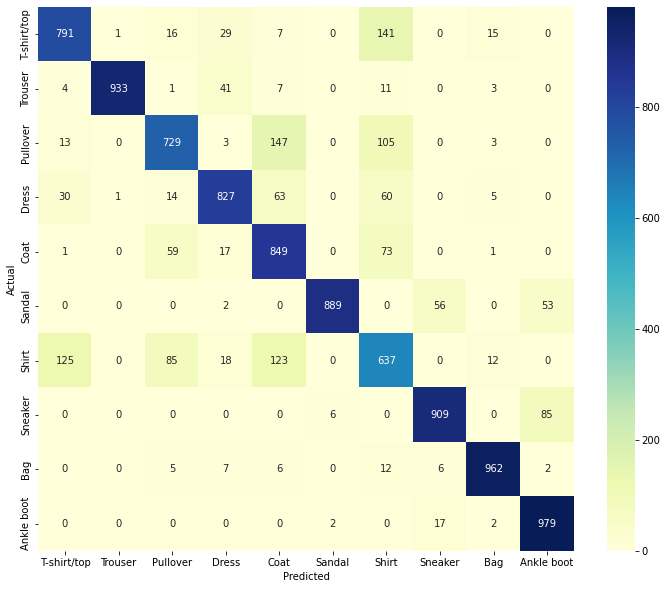

In [27]:
# confusion matrix
cmat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### best fitness

In [30]:
# genome with highest fitness score
genome = "NC 16 3 tanh;NC 6 3 swish;RC 6 3 tanh;RC 10 3 tanh;FL swish;"
model = train_model(genome, epochs=20, return_model=True, verbose=2, lr=0.01, lr_decay=0.1)

Training genome: NC 16 3 tanh;NC 6 3 swish;RC 6 3 tanh;RC 10 3 tanh;FL swish;
Model params: 3264
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        160       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 6)         870       
                                                                 
 Layer_2_RC (Conv2D)         (None, 13, 13, 6)         330       
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 10)          550       
                                                                 
 global_average_pooling2d_3   (None, 10)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)       

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/469           ETA: ?s - 

Epoch 2/20


0/469           ETA: ?s - 

Epoch 3/20


0/469           ETA: ?s - 

Epoch 4/20


0/469           ETA: ?s - 

Epoch 5/20


0/469           ETA: ?s - 

Epoch 6/20


0/469           ETA: ?s - 

Epoch 7/20


0/469           ETA: ?s - 

Epoch 8/20


0/469           ETA: ?s - 

Epoch 9/20


0/469           ETA: ?s - 

Epoch 10/20


0/469           ETA: ?s - 

Epoch 11/20


0/469           ETA: ?s - 

Epoch 12/20


0/469           ETA: ?s - 

Epoch 13/20


0/469           ETA: ?s - 

Epoch 14/20


0/469           ETA: ?s - 

Epoch 15/20


0/469           ETA: ?s - 

Epoch 16/20


0/469           ETA: ?s - 

Epoch 17/20


0/469           ETA: ?s - 

Epoch 18/20


0/469           ETA: ?s - 

Epoch 19/20


0/469           ETA: ?s - 

Epoch 00019: early stopping


In [31]:
# predict
y_pred = model.predict(x_test)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)

(10000, 10)
(10000,)


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75      1000
           1       0.99      0.94      0.96      1000
           2       0.79      0.58      0.66      1000
           3       0.83      0.82      0.82      1000
           4       0.66      0.67      0.67      1000
           5       0.97      0.90      0.93      1000
           6       0.48      0.48      0.48      1000
           7       0.87      0.94      0.90      1000
           8       0.90      0.94      0.92      1000
           9       0.94      0.92      0.93      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



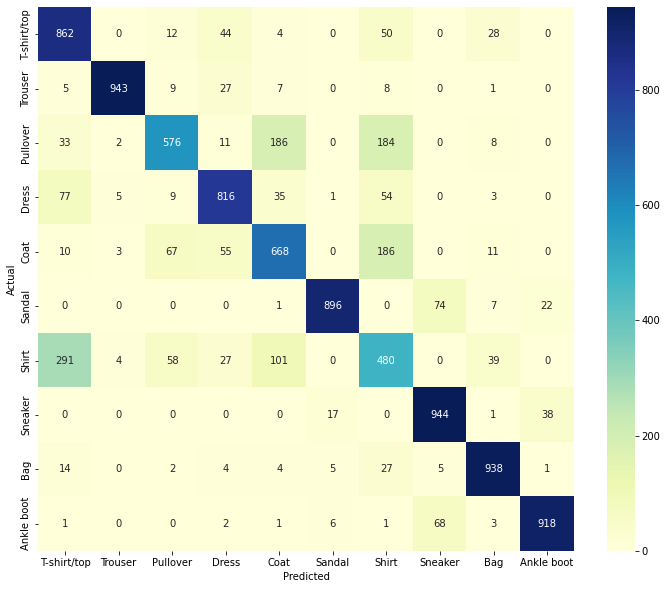

In [33]:
# confusion matrix
cmat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## analysis

In [ ]:
print(f'\tbest genome: {best_genome_overall}')
print(f'\tbest genome fitness: {best_genome_overall_fitness}')

best_genome_log = train_log_cache[best_genome_overall]
print(f'\tbest genome:: generation {best_genome_log[0]} | accuracy: {best_genome_log[1][0]:.4f} | num param: {best_genome_log[1][2]:} | time taken: {best_genome_log[1][3]} sec.')

	best genome: NC 16 3 tanh;NC 6 3 swish;RC 6 3 tanh;RC 10 3 tanh;FL swish;
	best genome fitness: 9.965752231967237
	best genome:: generation 1 | accuracy: 0.8063 | num param: 3264 | time taken: 183.51 sec.


In [ ]:
pd.options.display.max_colwidth = 40

In [ ]:
# creating log dataframe from log_cache
df_log = pd.DataFrame({"genome": train_log_cache.keys(),
                       "test_acc": [elem[1][0] for elem in train_log_cache.values()],
                       "train_acc": [elem[1][1] for elem in train_log_cache.values()],
                       "num_param": [elem[1][2] for elem in train_log_cache.values()],
                       "time_taken(sec)": [elem[1][3] for elem in train_log_cache.values()],
                    })

### best genome:fitness

In [ ]:
# prepare df
df_log["fitness"] = df_log['test_acc']*100/df_log['num_param'].apply(lambda x: math.log(x))
df_log["fitness_time"] = (df_log['test_acc']*100)/(df_log['num_param'].apply(lambda x: math.log(x)) * df_log['time_taken(sec)'])
df_log = df_log.round(4)

In [ ]:
# best model by fitness score
df_log.sort_values(by=["fitness"], ascending=False).head()

,genome,test_acc,train_acc,num_param,time_taken(sec),fitness,fitness_time
35,NC 16 3 tanh;NC 6 3 swish;RC 6 3 tan...,0.8063,0.8064,3264,183.51,9.9658,0.0543
12,NC 14 3 relu;NC 8 3 gelu;RC 12 3 tan...,0.8184,0.8240,4476,159.94,9.7353,0.0609
31,NC 14 3 relu;NC 8 3 gelu;RC 12 3 tan...,0.8413,0.8428,5830,153.03,9.7027,0.0634
28,NC 10 4 swish;NC 6 3 swish;RC 6 3 ta...,0.7757,0.7763,3426,176.80,9.5305,0.0539
24,NC 16 3 tanh;NC 6 3 swish;RC 6 3 tan...,0.7822,0.7851,3740,172.07,9.5079,0.0553


**From manual inspection, model: `NC 14 3 relu;NC 8 3 gelu;RC 12 3 tanh;RC 12 4 gelu;FL gelu;` seems a very good model. As it achieves accuracy of ~84% with 5.8k parameters.

### best genome:accuracy

In [ ]:
df_log.sort_values(by=["train_acc"], ascending=False).head()

,genome,test_acc,train_acc,num_param,time_taken(sec),fitness,fitness_time
29,NC 16 4 gelu;RC 10 4 relu;NC 8 4 gel...,0.8538,0.8563,8768,143.79,9.4043,0.0654
31,NC 14 3 relu;NC 8 3 gelu;RC 12 3 tan...,0.8413,0.8428,5830,153.03,9.7027,0.0634
6,NC 16 4 tanh;NC 12 4 tanh;NC 14 4 sw...,0.8236,0.8249,9736,163.85,8.9682,0.0547
12,NC 14 3 relu;NC 8 3 gelu;RC 12 3 tan...,0.8184,0.8240,4476,159.94,9.7353,0.0609
11,NC 4 5 gelu;NC 6 5 swish;RC 14 5 sig...,0.8223,0.8239,6504,144.66,9.3654,0.0647


### best genome:fitness_with_time

In [ ]:
# considering only models with more than 75% accuracy
df_log[df_log.test_acc > 0.75].sort_values(by=["fitness_time"], ascending=False).head()

,genome,test_acc,train_acc,num_param,time_taken(sec),fitness,fitness_time
23,NC 10 4 relu;RC 14 4 tanh;RC 14 4 re...,0.7548,0.7554,7184,66.05,8.5004,0.1287
2,NC 12 5 tanh;RC 10 5 sigmoid;RC 14 5...,0.7999,0.8049,8446,94.52,8.8470,0.0936
14,NC 6 5 relu;RC 14 5 sigmoid;RC 6 5 s...,0.7696,0.7746,5474,102.44,8.9408,0.0873
0,NC 8 4 sigmoid;RC 12 4 gelu;RC 12 4 ...,0.7831,0.7839,5482,113.01,9.0961,0.0805
25,NC 8 4 sigmoid;RC 12 4 gelu;RC 12 4 ...,0.7593,0.7616,5482,126.05,8.8196,0.0700


### plots

In [ ]:
fig = px.scatter(df_log, x="num_param", y="test_acc", color='fitness',
                 width=900, height=600, 
                 labels={
                     "num_param": "Number of parameters",
                     "test_acc": "Test Accuracy",
                 },
                title="Fitness: Parmeters Vs Test Accuracy"
                )
fig.update_traces(marker_size=10)
fig.show()

In [ ]:
fig = px.scatter(df_log, x="num_param", y="test_acc", color='fitness_time',
                 width=900, height=600, 
                 labels={
                     "num_param": "Number of parameters",
                     "test_acc": "Test Accuracy",
                 },
                title="Fitness with time: Parmeters Vs Test Accuracy"
                )
fig.update_traces(marker_size=10)
fig.show()

- From first figure, we can see that the best models as per fitness scores are in top left corner shown by bright yellow color. In lower figure, the color scheme is based on fitness as well as time taken to train the model. Here, we see that only few models are having bright colors and those are in top center.
- It means that the the models  in  top  left  corner  of  top figure were  achieving  higher accuracy scores with less number of parameters but they were taking more time to train. Hence, depending on the use case,we should consider all 3 parameters to pick the best model. 